# Computer Vision

## Assignment 3

Vedansh Agrawal <br>
2021112010

## Question 2: Contrastive Language-Image Pretraining

### Part 1:

First, let us load both the models, that is CLIP and the ImageNet.

In [12]:
import torch
import torchvision.models as models
from torchvision import transforms
import clip
import ast
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
import time

Below is the ResNet model initialized with ImageNet

In [2]:
resnet_imagenet = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V1)
resnet_imagenet.eval()
print("ResNet-50 with ImageNet Pretraining:")
print(resnet_imagenet)

/home/vedansh/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


ResNet-50 with ImageNet Pretraining:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64,

In [3]:
model, preprocess = clip.load("RN50")

print("CLIP Vision Encoder:")
print(model.encode_image)

CLIP Vision Encoder:
<bound method CLIP.encode_image of CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

Let us compare both the architectures of both models. Both model have different vision encoder models. Following are the differences:

- The initial architecture is a bit difference. The CLIP model has 3 conv layers while the IMAGENET has 1 conv layer.

- In the middle of every bottleneck layer, CLIP does an additional avgpool unlike in IMAGENET

- Additionally, in the clip encoder, after passing everything through to the RESNET50, it is also passed through a transformer encoder as well for additional processing.

### Part 2:

Here we will understand the IMAGENET dataset on which we will run both the models on.

(i) ImageNet uses a hierarchical structure for its labels, which is a lexical database for english. The labeling is structured ina tree like format in which the node represents the category of the object and the leaf nodes correspond to a specific label.

(ii) Synset is short for Synonym set. It is essentially a set of synonymous words that represent a common concept or category. It typically contains multiple words or phrases that are semantically related and each synset is assigned a unique identifier. Example: dog, pooch, canine, etc.

(iii) SynSets can pose a significant problems for visual recognition tasks.
- Ambiguity: Some synsets may encompass a wide range of visually diverse objects that share a common semantic concept. This ambiguity can make it challenging for algorithms to accurately distinguish between different instances within the same synset.
- Variability: Objects belonging to the same synset may exhibit significant variations in appearance, shape, size, color, and context. These variations can introduce complexity and variability into visual recognition tasks, making it harder to generalize across different instances of the same category.
- Fine-Grained Discrimination: Synsets may lack the granularity needed to distinguish between visually similar but semantically distinct objects. For example, different species of birds or breeds of dogs may belong to the same synset, making it difficult for algorithms to accurately identify specific subclasses within a broader category.

(iv) We can expect to encounter various visual differences, including:

- Scale Variation: Objects may appear at different scales within images, ranging from close-up views to distant perspectives. For example, a synset representing "car" may include images of cars of various sizes, from compact cars to trucks.
- Pose Variation: Objects can exhibit different poses or orientations within images, making them appear differently from different viewpoints. For instance, a synset representing "cat" may include images of cats in various poses, such as sitting, standing, or lying down.
- Appearance Variation: Objects may vary in appearance due to factors like lighting conditions, occlusion, background clutter, and object deformations. For example, a synset representing "apple" may include images of apples of different colors, shapes, and textures, depending on factors like ripeness and variety.

### Part 3

In this part we will set the CLIP model to classify images. 

In [4]:
def classify(image_path):
    with open("data.txt", "r") as file:
        labels = file.read()

    labels_dict = ast.literal_eval(labels)
    labels = list(labels_dict.values())
    text_label = [f"a photo of a {label}" for label in labels]
    text = clip.tokenize(text_label)

    image = preprocess(Image.open(image_path)).unsqueeze(0)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarity, text_label

def classify_imagenet(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
        
    input = preprocess(Image.open(image_path)).unsqueeze(0)
    with torch.no_grad():
        output = resnet_imagenet(input)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

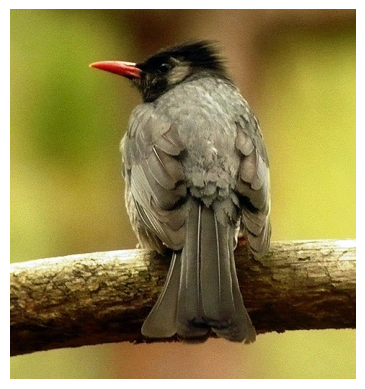


Top prediction:
a photo of a bulbul: 99.52%
a photo of a jacamar: 0.09%
a photo of a red-breasted merganser, Mergus serrator: 0.08%


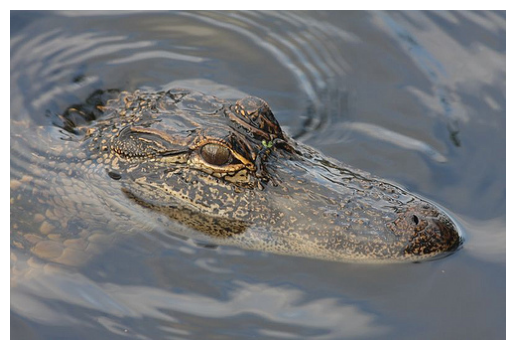


Top prediction:
a photo of a terrapin: 38.13%
a photo of a American alligator, Alligator mississipiensis: 23.97%
a photo of a mud turtle: 9.08%


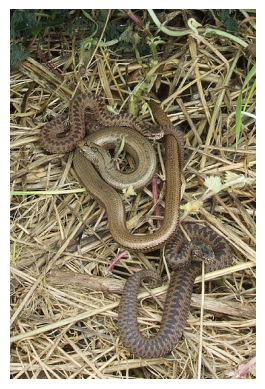


Top prediction:
a photo of a garter snake, grass snake: 57.10%
a photo of a thunder snake, worm snake, Carphophis amoenus: 18.86%
a photo of a night snake, Hypsiglena torquata: 3.95%


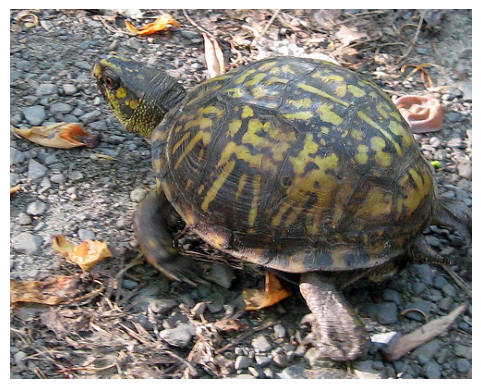


Top prediction:
a photo of a box turtle, box tortoise: 55.87%
a photo of a terrapin: 24.19%
a photo of a mud turtle: 17.23%


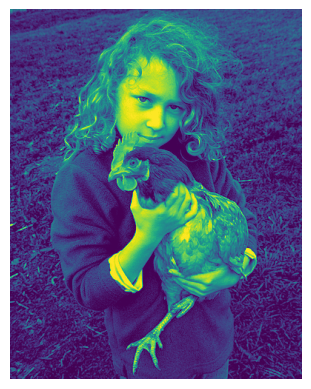


Top prediction:
a photo of a hen: 52.54%
a photo of a cock: 11.87%
a photo of a Brabancon griffon: 5.85%


In [11]:
images = ['bird.jpeg', 'crocodile.jpeg', 'snakes.jpeg', 'turtle.jpeg', 'hen.jpeg']


for image_path in images:
    similarity, labels = classify(image_path)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    values, indices = similarity[0].topk(3)
    print("\nTop prediction:")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

### Part 4:

In this part, we require to find images which work well with Clip but not with IMAGENET.

In [6]:
def get_sim(image_path):
    similarity, labels = classify(image_path)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    values, indices = similarity[0].topk(5)
    print("\nTop prediction(CLIP):")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

    sim = classify_imagenet(image_path)
    values, indices =  torch.topk(sim, 5)
    print("\nTop prediction(ImageNet):")
    for value, index in zip(values, indices):
        print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")

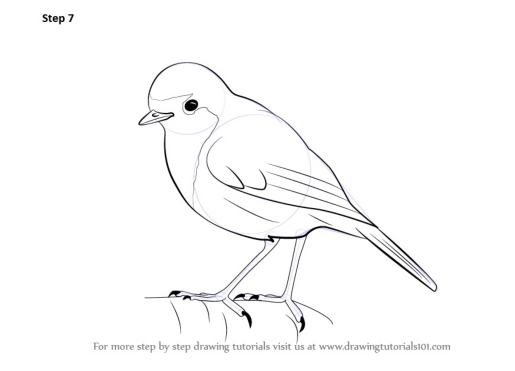


Top prediction(CLIP):
a photo of a junco, snowbird: 11.33%
a photo of a quail: 7.16%
a photo of a ptarmigan: 6.18%
a photo of a bulbul: 5.44%
a photo of a drake: 5.07%

Top prediction(ImageNet):
a photo of a quill, quill pen: 54.80%
a photo of a envelope: 17.94%
a photo of a ballpoint, ballpoint pen, ballpen, Biro: 4.50%
a photo of a web site, website, internet site, site: 2.07%
a photo of a centipede: 1.04%


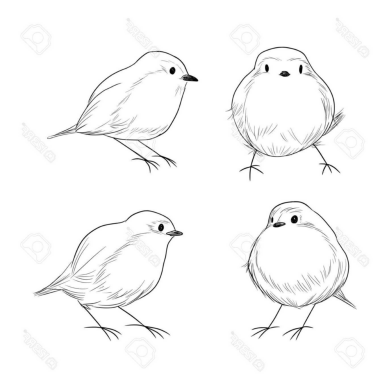


Top prediction(CLIP):
a photo of a quail: 8.43%
a photo of a junco, snowbird: 7.29%
a photo of a hen: 5.16%
a photo of a robin, American robin, Turdus migratorius: 4.70%
a photo of a indigo bunting, indigo finch, indigo bird, Passerina cyanea: 2.70%

Top prediction(ImageNet):
a photo of a envelope: 67.77%
a photo of a binder, ring-binder: 4.08%
a photo of a bubble: 1.71%
a photo of a Petri dish: 1.58%
a photo of a mouse, computer mouse: 1.52%


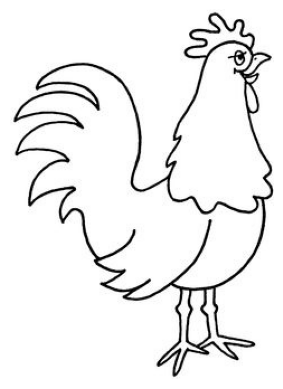


Top prediction(CLIP):
a photo of a cock: 19.44%
a photo of a hen: 12.93%
a photo of a Brabancon griffon: 9.26%
a photo of a partridge: 8.01%
a photo of a standard poodle: 2.14%

Top prediction(ImageNet):
a photo of a envelope: 33.28%
a photo of a pillow: 3.92%
a photo of a nematode, nematode worm, roundworm: 3.36%
a photo of a handkerchief, hankie, hanky, hankey: 2.59%
a photo of a rubber eraser, rubber, pencil eraser: 2.16%


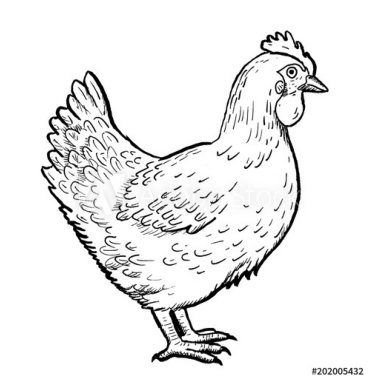


Top prediction(CLIP):
a photo of a hen: 50.23%
a photo of a cock: 41.39%
a photo of a quail: 1.73%
a photo of a partridge: 1.64%
a photo of a Brabancon griffon: 0.78%

Top prediction(ImageNet):
a photo of a chambered nautilus, pearly nautilus, nautilus: 12.38%
a photo of a sombrero: 7.44%
a photo of a lionfish: 4.22%
a photo of a flatworm, platyhelminth: 4.17%
a photo of a goblet: 3.88%


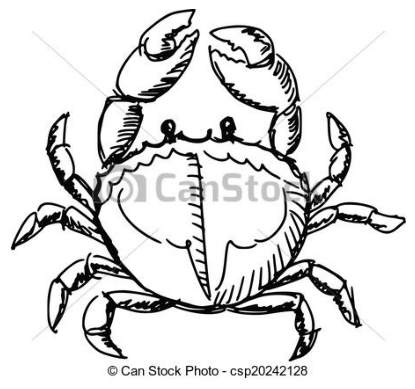


Top prediction(CLIP):
a photo of a fiddler crab: 22.28%
a photo of a crayfish, crawfish, crawdad, crawdaddy: 19.20%
a photo of a spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 18.81%
a photo of a dung beetle: 8.31%
a photo of a rock crab, Cancer irroratus: 5.55%

Top prediction(ImageNet):
a photo of a envelope: 12.67%
a photo of a maze, labyrinth: 9.11%
a photo of a pick, plectrum, plectron: 8.70%
a photo of a spider web, spider's web: 5.77%
a photo of a chain: 4.16%


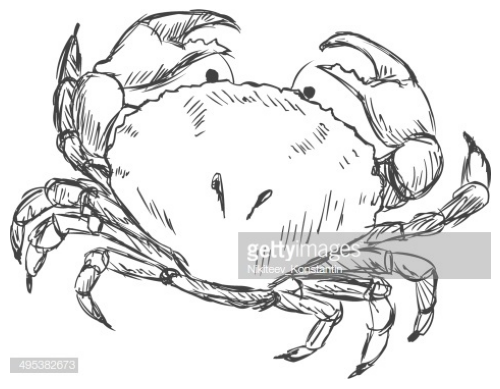


Top prediction(CLIP):
a photo of a crayfish, crawfish, crawdad, crawdaddy: 35.01%
a photo of a spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 31.39%
a photo of a Dungeness crab, Cancer magister: 4.94%
a photo of a hog, pig, grunter, squealer, Sus scrofa: 2.68%
a photo of a electric ray, crampfish, numbfish, torpedo: 1.96%

Top prediction(ImageNet):
a photo of a envelope: 25.11%
a photo of a nematode, nematode worm, roundworm: 11.64%
a photo of a comic book: 9.74%
a photo of a cup: 6.80%
a photo of a binder, ring-binder: 3.92%


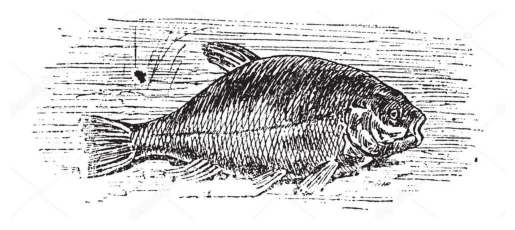


Top prediction(CLIP):
a photo of a tench, Tinca tinca: 18.37%
a photo of a beaver: 11.54%
a photo of a barracouta, snoek: 7.16%
a photo of a grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 5.63%
a photo of a triceratops: 4.10%

Top prediction(ImageNet):
a photo of a trilobite: 55.05%
a photo of a spider web, spider's web: 6.23%
a photo of a electric fan, blower: 3.21%
a photo of a envelope: 2.95%
a photo of a cleaver, meat cleaver, chopper: 2.07%


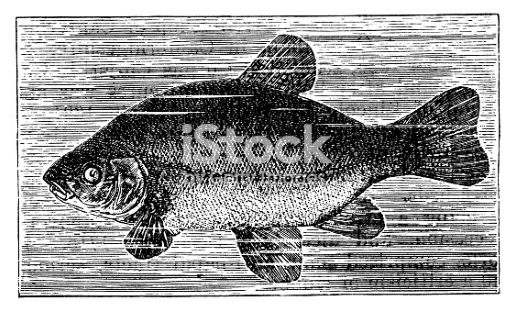


Top prediction(CLIP):
a photo of a tench, Tinca tinca: 31.12%
a photo of a coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 13.00%
a photo of a grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 11.50%
a photo of a barracouta, snoek: 7.78%
a photo of a goldfish, Carassius auratus: 5.92%

Top prediction(ImageNet):
a photo of a jigsaw puzzle: 17.11%
a photo of a warplane, military plane: 16.78%
a photo of a aircraft carrier, carrier, flattop, attack aircraft carrier: 14.21%
a photo of a triceratops: 8.83%
a photo of a coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 5.36%


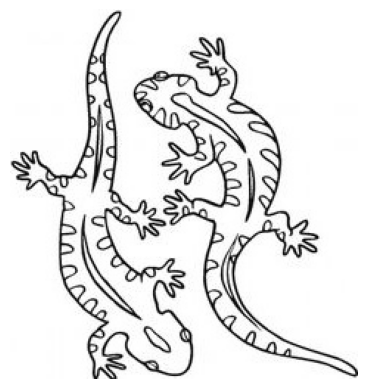


Top prediction(CLIP):
a photo of a spotted salamander, Ambystoma maculatum: 21.68%
a photo of a common newt, Triturus vulgaris: 13.32%
a photo of a alligator lizard: 10.12%
a photo of a European fire salamander, Salamandra salamandra: 4.00%
a photo of a common iguana, iguana, Iguana iguana: 3.58%

Top prediction(ImageNet):
a photo of a envelope: 28.26%
a photo of a nematode, nematode worm, roundworm: 13.89%
a photo of a handkerchief, hankie, hanky, hankey: 4.83%
a photo of a rubber eraser, rubber, pencil eraser: 3.23%
a photo of a pillow: 2.84%


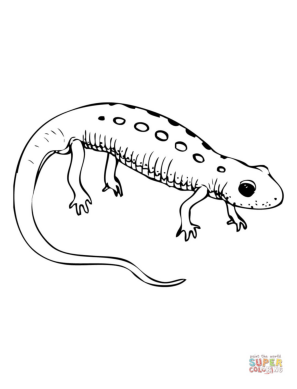


Top prediction(CLIP):
a photo of a spotted salamander, Ambystoma maculatum: 39.29%
a photo of a axolotl, mud puppy, Ambystoma mexicanum: 24.62%
a photo of a banded gecko: 18.67%
a photo of a whiptail, whiptail lizard: 3.07%
a photo of a common newt, Triturus vulgaris: 2.93%

Top prediction(ImageNet):
a photo of a envelope: 44.93%
a photo of a nematode, nematode worm, roundworm: 3.31%
a photo of a pick, plectrum, plectron: 2.95%
a photo of a rubber eraser, rubber, pencil eraser: 2.95%
a photo of a quill, quill pen: 1.89%


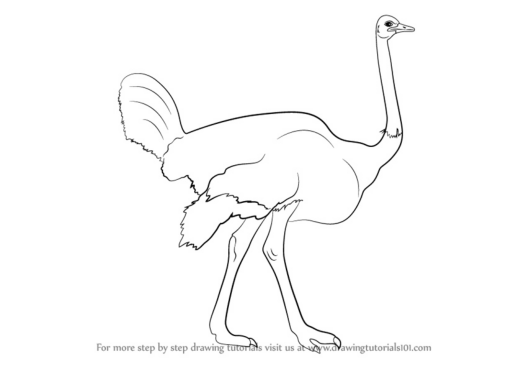


Top prediction(CLIP):
a photo of a Italian greyhound: 18.69%
a photo of a whippet: 12.10%
a photo of a spoonbill: 8.69%
a photo of a crane: 8.31%
a photo of a crane: 8.31%

Top prediction(ImageNet):
a photo of a envelope: 50.25%
a photo of a safety pin: 6.92%
a photo of a hook, claw: 6.07%
a photo of a nematode, nematode worm, roundworm: 4.78%
a photo of a web site, website, internet site, site: 2.54%


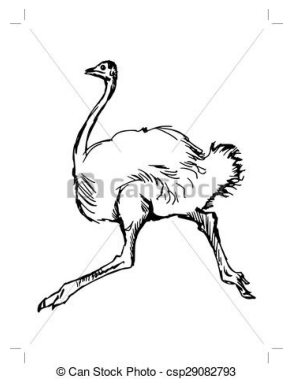


Top prediction(CLIP):
a photo of a ostrich, Struthio camelus: 61.14%
a photo of a crane: 9.89%
a photo of a crane: 9.89%
a photo of a bustard: 8.32%
a photo of a goose: 2.98%

Top prediction(ImageNet):
a photo of a comic book: 18.79%
a photo of a nematode, nematode worm, roundworm: 14.98%
a photo of a corkscrew, bottle screw: 11.50%
a photo of a envelope: 4.03%
a photo of a hook, claw: 3.64%


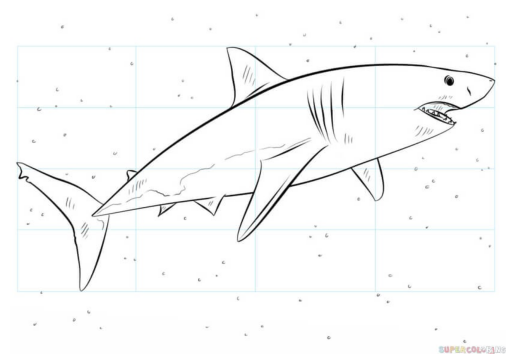


Top prediction(CLIP):
a photo of a great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 57.53%
a photo of a tiger shark, Galeocerdo cuvieri: 14.28%
a photo of a killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 6.21%
a photo of a dugong, Dugong dugon: 5.90%
a photo of a sturgeon: 2.43%

Top prediction(ImageNet):
a photo of a oscilloscope, scope, cathode-ray oscilloscope, CRO: 45.32%
a photo of a nematode, nematode worm, roundworm: 26.85%
a photo of a harvestman, daddy longlegs, Phalangium opilio: 2.68%
a photo of a toaster: 2.48%
a photo of a walking stick, walkingstick, stick insect: 2.33%


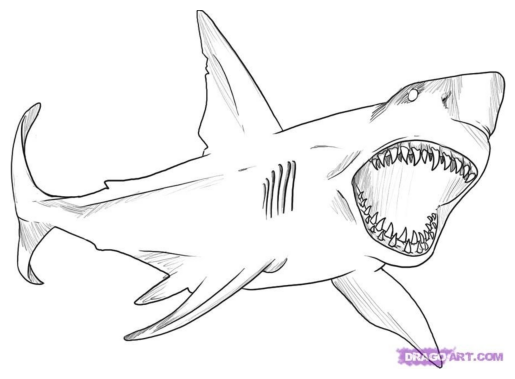


Top prediction(CLIP):
a photo of a great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 80.21%
a photo of a sturgeon: 8.80%
a photo of a hammerhead, hammerhead shark: 4.15%
a photo of a tiger shark, Galeocerdo cuvieri: 3.85%
a photo of a electric ray, crampfish, numbfish, torpedo: 0.65%

Top prediction(ImageNet):
a photo of a cup: 25.30%
a photo of a goblet: 9.67%
a photo of a red wine: 7.61%
a photo of a mixing bowl: 5.00%
a photo of a beer glass: 2.74%


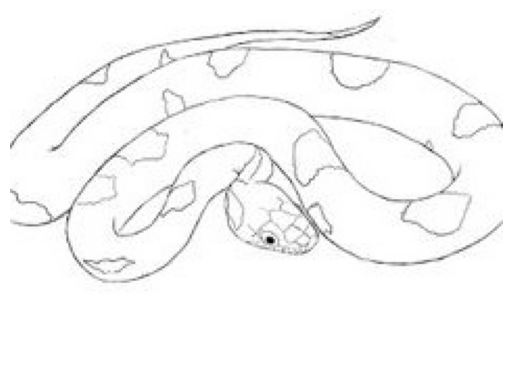


Top prediction(CLIP):
a photo of a electric ray, crampfish, numbfish, torpedo: 13.50%
a photo of a boa constrictor, Constrictor constrictor: 8.23%
a photo of a trilobite: 6.37%
a photo of a sturgeon: 3.47%
a photo of a rock python, rock snake, Python sebae: 3.06%

Top prediction(ImageNet):
a photo of a maze, labyrinth: 23.68%
a photo of a envelope: 8.66%
a photo of a hair slide: 6.37%
a photo of a rubber eraser, rubber, pencil eraser: 6.31%
a photo of a nematode, nematode worm, roundworm: 3.94%


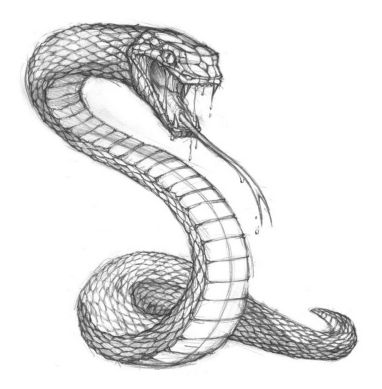


Top prediction(CLIP):
a photo of a water snake: 36.27%
a photo of a sea snake: 9.37%
a photo of a rock python, rock snake, Python sebae: 9.33%
a photo of a king snake, kingsnake: 8.90%
a photo of a diamondback, diamondback rattlesnake, Crotalus adamanteus: 7.48%

Top prediction(ImageNet):
a photo of a nematode, nematode worm, roundworm: 83.95%
a photo of a Indian cobra, Naja naja: 2.01%
a photo of a hook, claw: 1.95%
a photo of a knot: 1.88%
a photo of a coil, spiral, volute, whorl, helix: 1.55%


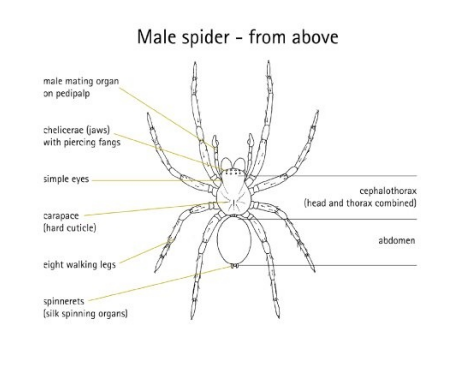


Top prediction(CLIP):
a photo of a garden spider, Aranea diademata: 49.32%
a photo of a barn spider, Araneus cavaticus: 25.48%
a photo of a wolf spider, hunting spider: 9.34%
a photo of a tarantula: 7.51%
a photo of a harvestman, daddy longlegs, Phalangium opilio: 2.97%

Top prediction(ImageNet):
a photo of a web site, website, internet site, site: 42.80%
a photo of a envelope: 9.97%
a photo of a menu: 9.61%
a photo of a hair slide: 6.09%
a photo of a nematode, nematode worm, roundworm: 4.28%


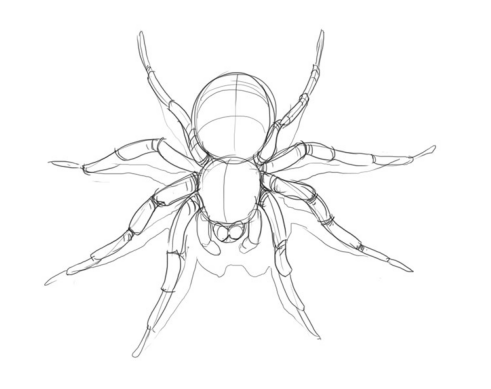


Top prediction(CLIP):
a photo of a garden spider, Aranea diademata: 13.97%
a photo of a spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 7.85%
a photo of a crayfish, crawfish, crawdad, crawdaddy: 7.00%
a photo of a ground beetle, carabid beetle: 6.18%
a photo of a harvestman, daddy longlegs, Phalangium opilio: 4.68%

Top prediction(ImageNet):
a photo of a tick: 13.78%
a photo of a hair slide: 9.01%
a photo of a envelope: 7.20%
a photo of a handkerchief, hankie, hanky, hankey: 5.48%
a photo of a centipede: 3.81%


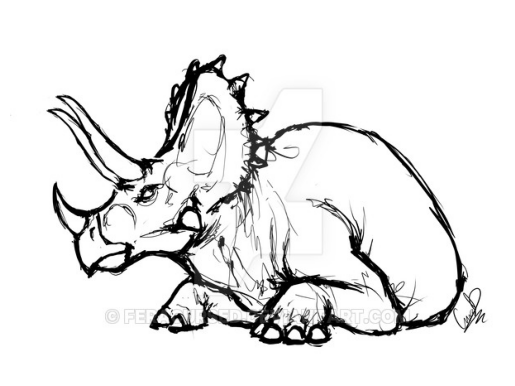


Top prediction(CLIP):
a photo of a triceratops: 56.18%
a photo of a wild boar, boar, Sus scrofa: 4.32%
a photo of a hyena, hyaena: 4.15%
a photo of a dogsled, dog sled, dog sleigh: 2.71%
 a photo of a ox: 2.67%

Top prediction(ImageNet):
a photo of a binder, ring-binder: 6.01%
a photo of a nematode, nematode worm, roundworm: 5.21%
a photo of a envelope: 4.63%
a photo of a laptop, laptop computer: 4.05%
a photo of a cassette: 3.51%


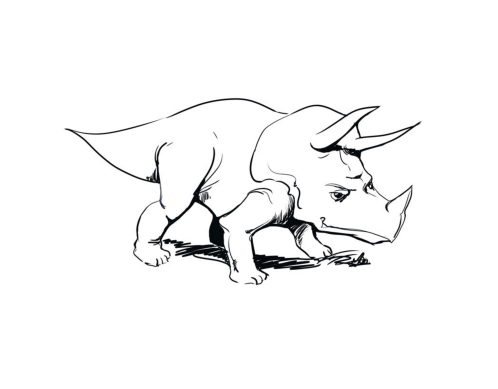


Top prediction(CLIP):
a photo of a triceratops: 86.17%
a photo of a Brabancon griffon: 1.84%
a photo of a wild boar, boar, Sus scrofa: 1.33%
 a photo of a ox: 0.89%
a photo of a warthog: 0.55%

Top prediction(ImageNet):
a photo of a envelope: 20.06%
a photo of a jigsaw puzzle: 10.41%
a photo of a comic book: 8.51%
a photo of a jersey, T-shirt, tee shirt: 3.27%
a photo of a rubber eraser, rubber, pencil eraser: 2.93%


In [10]:
image_directory = 'Works_well'
folders = sorted([img for img in os.listdir(image_directory)])

for folder in folders:
    folder_path = os.path.join(image_directory, folder)

    for image in os.listdir(folder_path):
        file_path = os.path.join(folder_path, image)
        get_sim(file_path)

These are images taken from ImageNet-Sketch dataset. The reason it does not predict well using imagenet is because imagenet was trained on images which have alot of details. These sketches lack detail so it is harder for imagenet to predict on these. However if we choose sketches with high details, then imagenet can somewhat give a good confidence score on the right class.

Now we need to find images which work well with imagenet and not with clip.

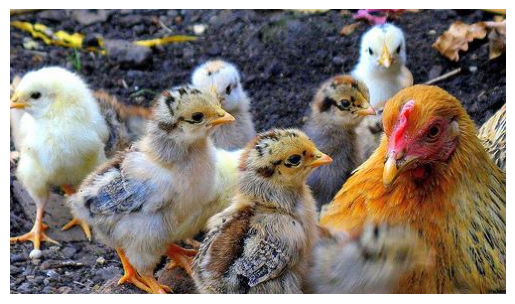


Top prediction(CLIP):
a photo of a prairie chicken, prairie grouse, prairie fowl: 46.72%
a photo of a hen: 31.01%
a photo of a Brabancon griffon: 4.83%
a photo of a quail: 3.25%
a photo of a partridge: 2.48%

Top prediction(ImageNet):
a photo of a hen: 94.50%
a photo of a partridge: 1.72%
a photo of a cock: 1.46%
a photo of a goose: 0.32%
a photo of a ruffed grouse, partridge, Bonasa umbellus: 0.26%


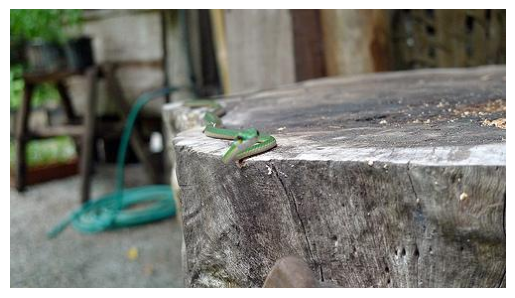


Top prediction(CLIP):
a photo of a green lizard, Lacerta viridis: 31.61%
a photo of a tree frog, tree-frog: 30.80%
a photo of a American chameleon, anole, Anolis carolinensis: 19.15%
a photo of a green mamba: 6.28%
a photo of a green snake, grass snake: 4.61%

Top prediction(ImageNet):
a photo of a green lizard, Lacerta viridis: 29.07%
a photo of a American chameleon, anole, Anolis carolinensis: 24.30%
a photo of a vine snake: 16.69%
a photo of a green mamba: 7.60%
a photo of a tree frog, tree-frog: 2.88%


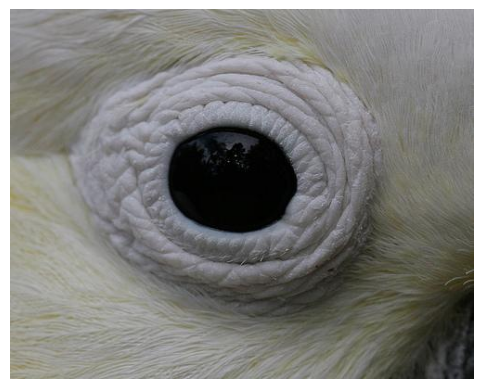


Top prediction(CLIP):
a photo of a pelican: 24.15%
a photo of a spoonbill: 19.99%
a photo of a vulture: 15.64%
a photo of a goose: 14.22%
a photo of a cock: 3.41%

Top prediction(ImageNet):
a photo of a sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 99.96%
a photo of a macaw: 0.02%
a photo of a vulture: 0.01%
a photo of a African grey, African gray, Psittacus erithacus: 0.00%
a photo of a kite: 0.00%


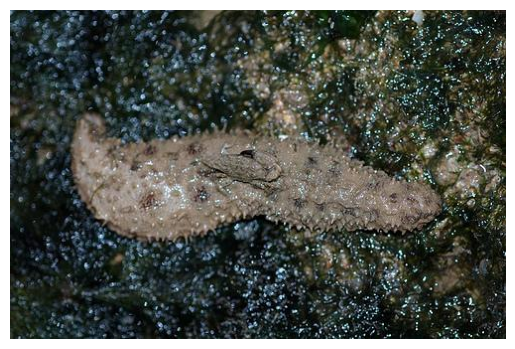


Top prediction(CLIP):
a photo of a sea cucumber, holothurian: 30.34%
a photo of a starfish, sea star: 23.01%
a photo of a flatworm, platyhelminth: 20.37%
a photo of a slug: 5.05%
a photo of a tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 1.69%

Top prediction(ImageNet):
a photo of a horned viper, cerastes, sand viper, horned asp, Cerastes cornutus: 44.28%
a photo of a sidewinder, horned rattlesnake, Crotalus cerastes: 29.64%
a photo of a sea cucumber, holothurian: 14.07%
a photo of a tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 3.99%
a photo of a banded gecko: 1.96%


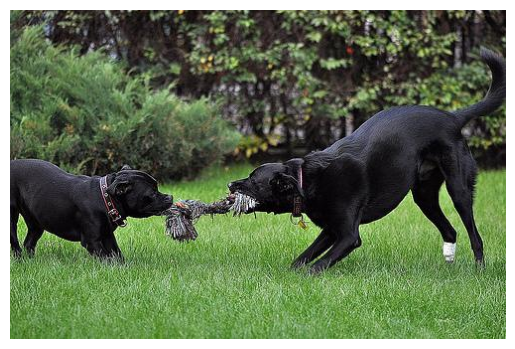


Top prediction(CLIP):
a photo of a flat-coated retriever: 46.68%
a photo of a curly-coated retriever: 17.36%
a photo of a giant schnauzer: 11.97%
a photo of a Labrador retriever: 4.08%
a photo of a Newfoundland, Newfoundland dog: 2.44%

Top prediction(ImageNet):
a photo of a staffordshire bullterrier, Staffordshire bull terrier: 96.30%
a photo of a American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 1.46%
a photo of a giant schnauzer: 0.95%
a photo of a Labrador retriever: 0.43%
a photo of a standard schnauzer: 0.13%


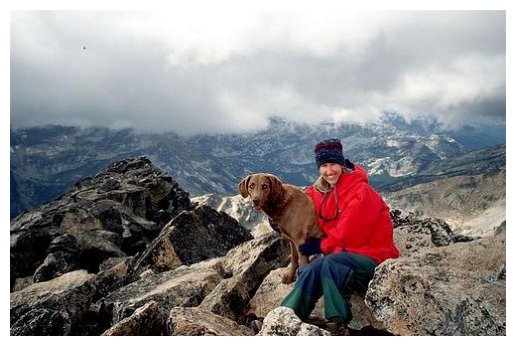


Top prediction(CLIP):
a photo of a vizsla, Hungarian pointer: 18.02%
a photo of a Weimaraner: 8.57%
a photo of a bloodhound, sleuthhound: 6.85%
a photo of a Rhodesian ridgeback: 6.24%
a photo of a basset, basset hound: 4.72%

Top prediction(ImageNet):
a photo of a cliff, drop, drop-off: 42.63%
a photo of a alp: 13.16%
a photo of a volcano: 5.05%
a photo of a Welsh springer spaniel: 3.38%
a photo of a mountain bike, all-terrain bike, off-roader: 3.07%


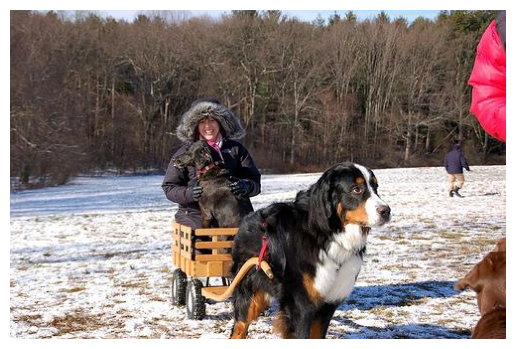


Top prediction(CLIP):
a photo of a Bernese mountain dog: 66.42%
a photo of a dogsled, dog sled, dog sleigh: 8.68%
a photo of a Greater Swiss Mountain dog: 5.08%
a photo of a dalmatian, coach dog, carriage dog: 3.02%
a photo of a Gordon setter: 2.23%

Top prediction(ImageNet):
a photo of a Bernese mountain dog: 54.73%
a photo of a Greater Swiss Mountain dog: 29.58%
a photo of a Appenzeller: 8.31%
a photo of a EntleBucher: 2.34%
a photo of a Gordon setter: 1.39%


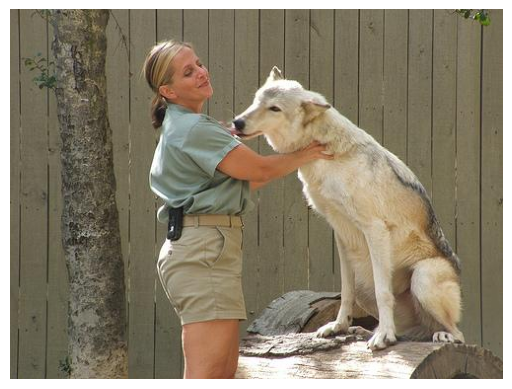


Top prediction(CLIP):
a photo of a borzoi, Russian wolfhound: 41.51%
a photo of a white wolf, Arctic wolf, Canis lupus tundrarum: 18.25%
a photo of a saluki, gazelle hound: 8.66%
a photo of a Irish wolfhound: 6.19%
a photo of a timber wolf, grey wolf, gray wolf, Canis lupus: 5.35%

Top prediction(ImageNet):
a photo of a timber wolf, grey wolf, gray wolf, Canis lupus: 71.87%
a photo of a white wolf, Arctic wolf, Canis lupus tundrarum: 9.11%
a photo of a dingo, warrigal, warragal, Canis dingo: 5.32%
a photo of a red wolf, maned wolf, Canis rufus, Canis niger: 4.30%
a photo of a Eskimo dog, husky: 2.36%


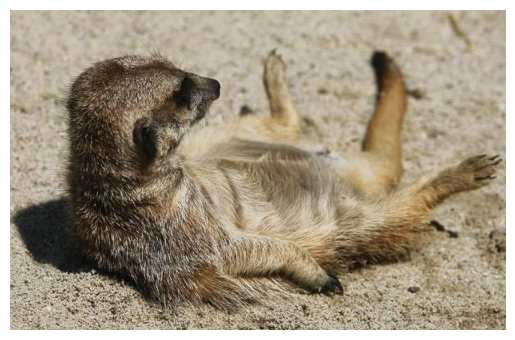


Top prediction(CLIP):
a photo of a coyote, prairie wolf, brush wolf, Canis latrans: 29.50%
a photo of a red wolf, maned wolf, Canis rufus, Canis niger: 17.29%
a photo of a dingo, warrigal, warragal, Canis dingo: 8.02%
a photo of a Border terrier: 7.73%
a photo of a hyena, hyaena: 6.38%

Top prediction(ImageNet):
a photo of a meerkat, mierkat: 97.99%
a photo of a mongoose: 2.00%
a photo of a marmot: 0.01%
a photo of a fox squirrel, eastern fox squirrel, Sciurus niger: 0.00%
a photo of a hyena, hyaena: 0.00%


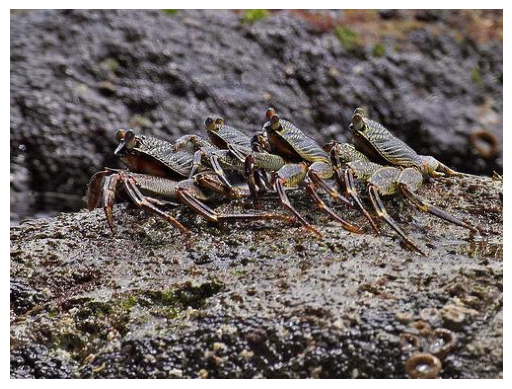


Top prediction(CLIP):
a photo of a cricket: 28.29%
a photo of a centipede: 14.46%
a photo of a scorpion: 14.23%
a photo of a crayfish, crawfish, crawdad, crawdaddy: 13.23%
a photo of a fiddler crab: 6.80%

Top prediction(ImageNet):
a photo of a rock crab, Cancer irroratus: 87.88%
a photo of a scorpion: 7.52%
a photo of a fiddler crab: 3.52%
a photo of a spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish: 0.52%
a photo of a crayfish, crawfish, crawdad, crawdaddy: 0.21%


In [23]:
image_directory = 'Does_not_work'
folders = sorted([img for img in os.listdir(image_directory)])

for folder in folders:
    folder_path = os.path.join(image_directory, folder)
    get_sim(folder_path)

Thes images came from the imagenet dataset. Since the imagenet model was trained on this model, it performs well on it however as the images seem very unclear, it is difficult for the clip model to make predictions.